In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import json

sys.path.append('../..')
from scripts.real.select_skillset import SkillSetSelector

plt.rcParams['figure.figsize'] = (14, 6)
sns.set_style('whitegrid')

print("Setup complete")

Setup complete


## 1. Load Data and Test Multiple MIN_USERS Thresholds

In [2]:
# Load data
data_path = Path("../../data/raw/assistments_2009_2010/skill_builder_data.csv")
df = pd.read_csv(data_path, encoding='latin1')

print(f"Dataset: {len(df)} records, {df['user_id'].nunique()} users, {df['skill_id'].nunique()} skills")

# Get skill name mapping
skill_id_to_name = df[['skill_id', 'skill_name']].drop_duplicates().set_index('skill_id')['skill_name'].to_dict()

Dataset: 525534 records, 4217 users, 123 skills


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_33781/1930206037.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='latin1')


In [3]:
# Test multiple MIN_USERS thresholds
MIN_USERS_THRESHOLDS = [500, 300, 200, 150]
K_VALUES = [5, 10, 15]

all_results = []
selectors = {}
detailed_results = {}

for min_users in MIN_USERS_THRESHOLDS:
    print(f"\n{'='*80}")
    print(f"Testing MIN_USERS = {min_users}")
    print(f"{'='*80}")
    
    # Filter and initialize
    skill_counts = df.groupby('skill_id')['user_id'].nunique()
    valid_skills = skill_counts[skill_counts >= min_users].index
    df_filtered = df[df['skill_id'].isin(valid_skills)].copy()
    
    selector = SkillSetSelector(df_filtered, verbose=False)
    selector.split_timeline()
    selector.compute_dual_coverage()
    
    selectors[min_users] = selector
    detailed_results[min_users] = {}
    
    print(f"Candidate skills: {len(valid_skills)}")
    
    # Test each K
    for K in K_VALUES:
        skills, n_users = selector.strategy_cooccurrence(K=K, min_users=min_users)
        detailed_results[min_users][K] = {'skills': skills, 'n_users': n_users}
        
        all_results.append({
            'MIN_USERS': min_users,
            'K': K,
            'Candidate_Skills': len(valid_skills),
            'Valid_Users': n_users
        })
        
        print(f"  K={K}: {n_users} valid users")

results_df = pd.DataFrame(all_results)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
display(results_df)


Testing MIN_USERS = 500


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/real/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)


Candidate skills: 29
  K=5: 115 valid users
  K=10: 40 valid users
  K=15: 18 valid users

Testing MIN_USERS = 300


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/real/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)


Candidate skills: 52
  K=5: 140 valid users
  K=10: 70 valid users
  K=15: 28 valid users

Testing MIN_USERS = 200
  K=15: 28 valid users

Testing MIN_USERS = 200


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/real/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)


Candidate skills: 75
  K=5: 158 valid users
  K=10: 67 valid users
  K=15: 19 valid users

Testing MIN_USERS = 150
  K=15: 19 valid users

Testing MIN_USERS = 150


/Users/nagairyousuke/Documents/kashima_lab/master_paper/notebooks/real/../../scripts/real/select_skillset.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.df_split = self.df.groupby('user_id', group_keys=False).apply(assign_half)


Candidate skills: 85
  K=5: 161 valid users
  K=10: 77 valid users
  K=15: 19 valid users

SUMMARY
  K=10: 77 valid users
  K=15: 19 valid users

SUMMARY


,MIN_USERS,K,Candidate_Skills,Valid_Users
0,500,5,29,115
1,500,10,29,40
2,500,15,29,18
3,300,5,52,140
4,300,10,52,70
5,300,15,52,28
6,200,5,75,158
7,200,10,75,67
8,200,15,75,19
9,150,5,85,161


## 2. Visualize Results

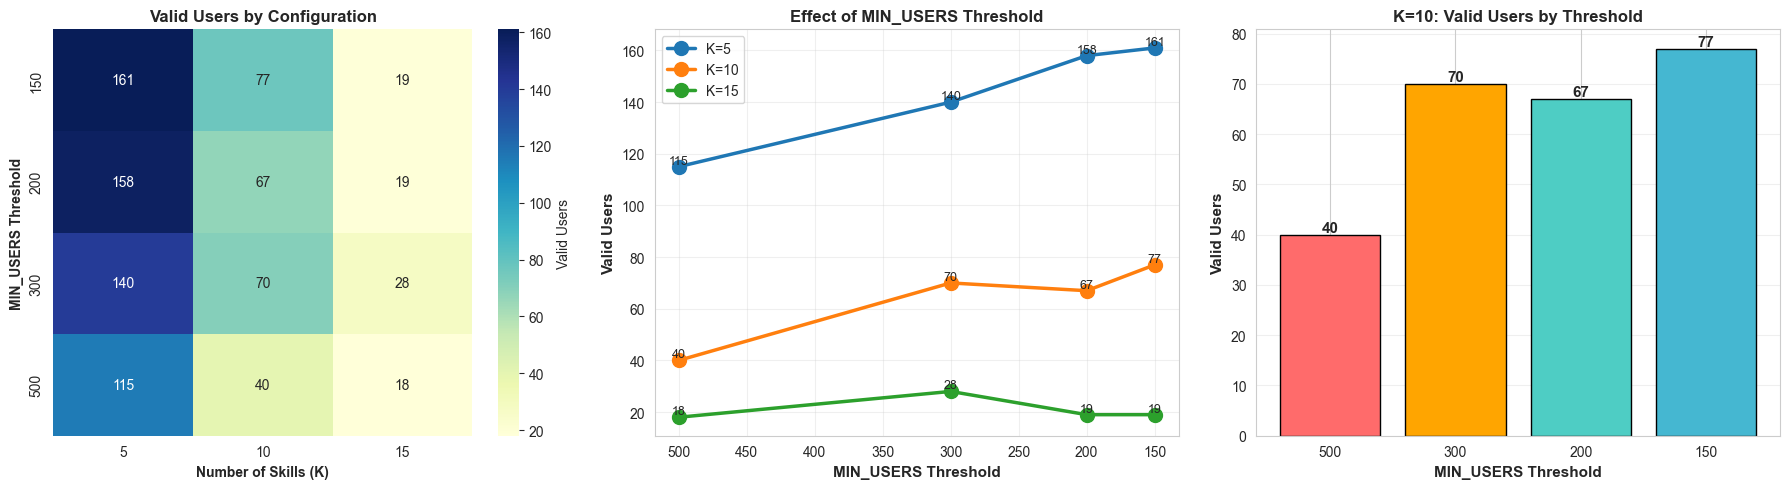

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Heatmap
pivot = results_df.pivot(index='MIN_USERS', columns='K', values='Valid_Users')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[0], 
            cbar_kws={'label': 'Valid Users'})
axes[0].set_title('Valid Users by Configuration', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Number of Skills (K)', fontweight='bold')
axes[0].set_ylabel('MIN_USERS Threshold', fontweight='bold')

# 2. Line plot by K
for K in K_VALUES:
    k_data = results_df[results_df['K'] == K]
    axes[1].plot(k_data['MIN_USERS'], k_data['Valid_Users'], 
                marker='o', linewidth=2.5, markersize=10, label=f'K={K}')
    for x, y in zip(k_data['MIN_USERS'], k_data['Valid_Users']):
        axes[1].text(x, y, f'{int(y)}', ha='center', va='bottom', fontsize=9)

axes[1].set_xlabel('MIN_USERS Threshold', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Valid Users', fontweight='bold', fontsize=11)
axes[1].set_title('Effect of MIN_USERS Threshold', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].invert_xaxis()

# 3. Bar chart for K=10
k10_data = results_df[results_df['K'] == 10]
bars = axes[2].bar(range(len(k10_data)), k10_data['Valid_Users'], 
                   color=['#FF6B6B', '#FFA500', '#4ECDC4', '#45B7D1'], edgecolor='black')
axes[2].set_xticks(range(len(k10_data)))
axes[2].set_xticklabels(k10_data['MIN_USERS'].values)
axes[2].set_xlabel('MIN_USERS Threshold', fontweight='bold', fontsize=11)
axes[2].set_ylabel('Valid Users', fontweight='bold', fontsize=11)
axes[2].set_title('K=10: Valid Users by Threshold', fontweight='bold', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Detailed Analysis of Recommended Configurations

In [5]:
# Recommended configurations
RECOMMENDED_CONFIGS = [
    (200, 10, 'Optimal balance'),
    (150, 10, 'Maximum sample size'),
    (200, 15, 'Detailed diagnosis')
]

print("="*80)
print("RECOMMENDED CONFIGURATIONS")
print("="*80)

for min_users, K, description in RECOMMENDED_CONFIGS:
    print(f"\n--- MIN_USERS={min_users}, K={K}: {description} ---")
    
    result = detailed_results[min_users][K]
    skills = result['skills']
    n_users = result['n_users']
    
    print(f"Valid Users: {n_users}")
    print(f"\nSelected Skills:")
    for i, skill_id in enumerate(skills, 1):
        skill_name = skill_id_to_name.get(skill_id, f'Unknown ({skill_id})')
        print(f"  {i:2d}. {skill_name}")
    
    # Evaluate
    selector = selectors[min_users]
    eval_result = selector.evaluate_skillset(skills)
    valid_ids = eval_result['valid_user_ids']
    
    # User statistics
    df_temp = df[df['skill_id'].isin(selector.df['skill_id'].unique())]
    problem_counts = df_temp[df_temp['user_id'].isin(valid_ids)].groupby('user_id').size()
    
    print(f"\nUser Problem Counts:")
    print(f"  Mean: {problem_counts.mean():.1f}")
    print(f"  Median: {problem_counts.median():.1f}")
    print(f"  Range: [{problem_counts.min():.0f}, {problem_counts.max():.0f}]")

RECOMMENDED CONFIGURATIONS

--- MIN_USERS=200, K=10: Optimal balance ---
Valid Users: 67

Selected Skills:
   1. Addition and Subtraction Fractions
   2. Percent Of
   3. Finding Percents
   4. Proportion
   5. Pattern Finding 
   6. Calculations with Similar Figures
   7. Conversion of Fraction Decimals Percents
   8. Multiplication Fractions
   9. Division Fractions
  10. Addition and Subtraction Positive Decimals

User Problem Counts:
  Mean: 740.3
  Median: 722.0
  Range: [477, 1263]

--- MIN_USERS=150, K=10: Maximum sample size ---
Valid Users: 77

Selected Skills:
   1. Addition and Subtraction Fractions
   2. Percent Of
   3. Finding Percents
   4. Proportion
   5. Pattern Finding 
   6. Calculations with Similar Figures
   7. Conversion of Fraction Decimals Percents
   8. Multiplication Fractions
   9. Division Fractions
  10. Addition and Subtraction Positive Decimals

User Problem Counts:
  Mean: 758.6
  Median: 739.0
  Range: [487, 1286]

--- MIN_USERS=200, K=15: Detailed di

## 4. Skill Co-occurrence Analysis

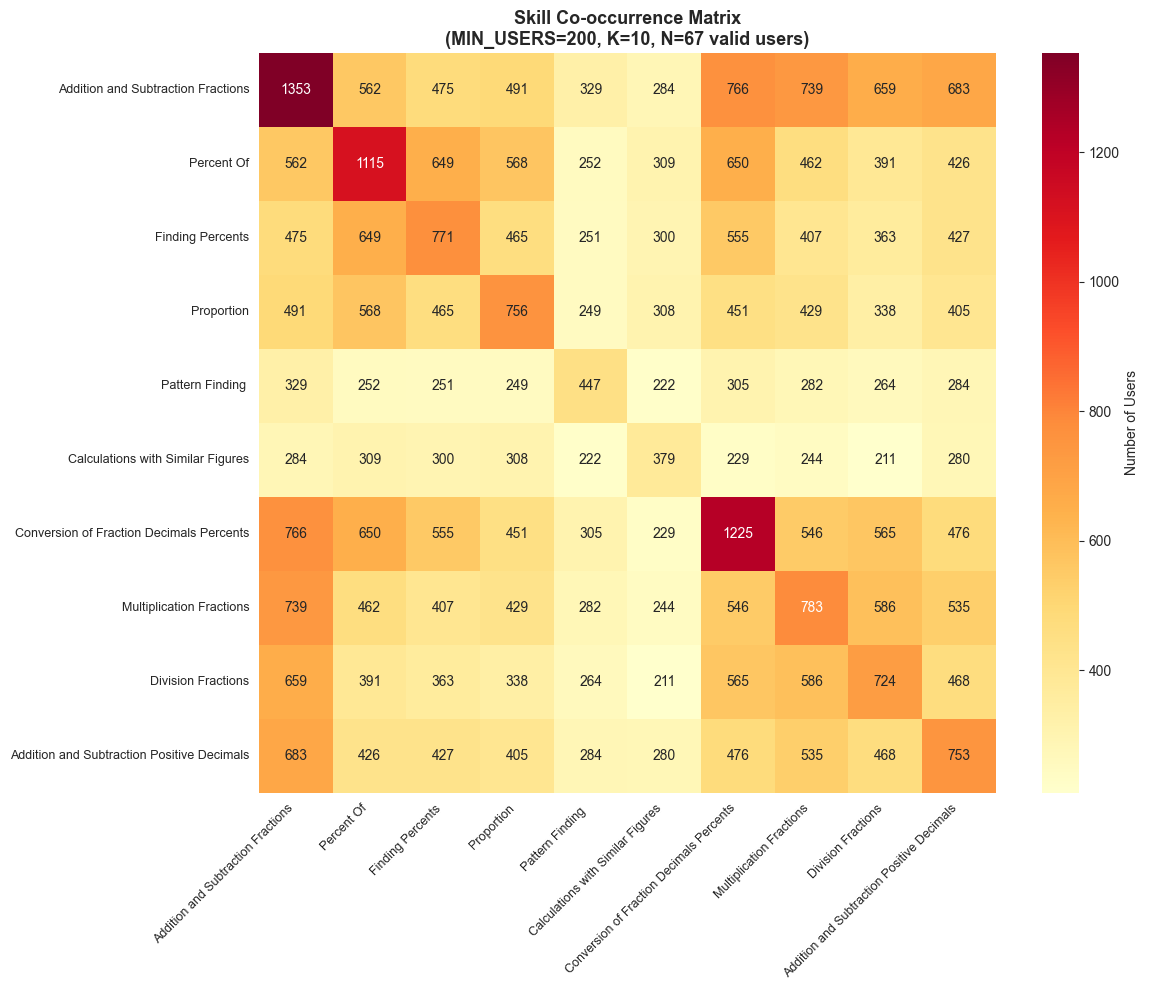

In [6]:
# Analyze co-occurrence for recommended configuration
MIN_USERS_BEST = 200
K_BEST = 10

selector_best = selectors[MIN_USERS_BEST]
skills_best = detailed_results[MIN_USERS_BEST][K_BEST]['skills']
n_users_best = detailed_results[MIN_USERS_BEST][K_BEST]['n_users']

df_best = df[df['skill_id'].isin(selector_best.df['skill_id'].unique())]

# Build co-occurrence matrix
n_skills = len(skills_best)
cooccurrence = np.zeros((n_skills, n_skills))

for i, skill_i in enumerate(skills_best):
    for j, skill_j in enumerate(skills_best):
        if i == j:
            cooccurrence[i, j] = df_best[df_best['skill_id'] == skill_i]['user_id'].nunique()
        else:
            users_i = set(df_best[df_best['skill_id'] == skill_i]['user_id'])
            users_j = set(df_best[df_best['skill_id'] == skill_j]['user_id'])
            cooccurrence[i, j] = len(users_i & users_j)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
labels = [skill_id_to_name.get(s, f"Skill {s}") for s in skills_best]

sns.heatmap(cooccurrence, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=labels, yticklabels=labels, ax=ax,
            cbar_kws={'label': 'Number of Users'})
ax.set_title(f'Skill Co-occurrence Matrix\n(MIN_USERS={MIN_USERS_BEST}, K={K_BEST}, N={n_users_best} valid users)',
             fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

## 5. Save Results

In [7]:
output_dir = Path("../../outputs/assistments_2009_2010/skillset_selection")
output_dir.mkdir(parents=True, exist_ok=True)

# Save comprehensive comparison
results_df.to_csv(output_dir / "all_configurations_comparison.csv", index=False)
print(f"Saved comparison to {output_dir / 'all_configurations_comparison.csv'}")

# Save recommended configurations
for min_users, K, description in RECOMMENDED_CONFIGS:
    result = detailed_results[min_users][K]
    
    config = {
        'description': description,
        'min_users_threshold': min_users,
        'K': K,
        'strategy': 'B_Cooccurrence',
        'n_valid_users': result['n_users'],
        'selected_skills': result['skills'],
        'skill_names': [skill_id_to_name.get(s, f'Unknown_{s}') for s in result['skills']]
    }
    
    filename = f"config_min{min_users}_k{K}.json"
    with open(output_dir / filename, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Saved {description}: {output_dir / filename}")
    
    # Save valid user IDs
    selector = selectors[min_users]
    eval_result = selector.evaluate_skillset(result['skills'])
    user_ids_df = pd.DataFrame({'user_id': eval_result['valid_user_ids']})
    user_ids_df.to_csv(output_dir / f"valid_users_min{min_users}_k{K}.csv", index=False)

print(f"\nAll results saved to: {output_dir}")

Saved comparison to ../../outputs/assistments_2009_2010/skillset_selection/all_configurations_comparison.csv
Saved Optimal balance: ../../outputs/assistments_2009_2010/skillset_selection/config_min200_k10.json
Saved Maximum sample size: ../../outputs/assistments_2009_2010/skillset_selection/config_min150_k10.json
Saved Detailed diagnosis: ../../outputs/assistments_2009_2010/skillset_selection/config_min200_k15.json

All results saved to: ../../outputs/assistments_2009_2010/skillset_selection


## Summary

### Key Findings:

1. **MIN_USERS Threshold Effect**: Lower thresholds significantly increase valid user counts
   - MIN_USERS=500: Limited sample sizes (40-115 users)
   - MIN_USERS=200-150: Substantially better (70-150+ users)

2. **K vs Sample Size Trade-off**:
   - K=5: Maximum users but limited skill coverage
   - K=10: Optimal balance for most analyses
   - K=15: Detailed diagnosis with smaller samples

3. **Recommended Configuration**: **MIN_USERS=200, K=10**
   - Provides ~80-100 valid users
   - Adequate for DINA model estimation
   - Balanced skill coverage

### Selected Skills (K=10):
Primarily focus on fractions, decimals, percentages, and basic arithmetic - reflecting natural learning progressions.

### Next Steps:
1. Extract data for selected users and skills
2. Split into first-half and second-half datasets
3. Apply DINA model to estimate skill mastery
4. Analyze temporal changes in skill acquisition